# Expanding window features
22 March 2024   
Conda environment: `time-series`

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

from feature_engine.timeseries.forecasting import ExpandingWindowFeatures

In [2]:
# Configs
# Plot configs:
sns.set_context("paper", font_scale= 1.5)
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plotsize = (22, 5)
plt.rcParams['figure.figsize'] = plotsize
# Pandas config
pd.options.display.float_format = '{:,.4f}'.format
pd.options.display.max_columns = 200

Let's create a function to compute the median absolute deviation which is defined as: $MAD = median(|x_i - median(x)|)$

In [4]:
# Functions
def mad(x):
    """Compute the median absolute deviation: MAD
    Args:
        x: input value
    Returns: mad
    """
    return np.median(np.abs(x - np.median(x)))

## 1) Input data

In [5]:
data = pd.read_csv(
    "../Datasets/victoria_electricity_demand.csv",
    usecols=["demand", "temperature", "date_time"],
    index_col=["date_time"],
    parse_dates=["date_time"],
)
# Use a subset of the data
data = data.loc["2010":]

data.head()

,demand,temperature
date_time,,
2010-01-01 00:00:00,"8,314.4487",21.5250
2010-01-01 01:00:00,"8,267.1873",22.4000
2010-01-01 02:00:00,"7,394.5284",22.1500
2010-01-01 03:00:00,"6,952.0475",21.8000
2010-01-01 04:00:00,"6,867.1996",20.2500


## 2) Expanding window features

### 2.1) Pandas: expanding window features

In [6]:
df = data.copy(deep=True)

In [7]:
result = (
    df["demand"]
    .expanding()  # Use `expanding` rather than `rolling`.
    .agg(["mean", "std", mad]) # Pick statistics.
    .shift(freq="1H") # Lag by 1 hour to avoid data leakage.
).add_prefix("demand_expanding_window_")

result

,demand_expanding_window_mean,demand_expanding_window_std,demand_expanding_window_mad
date_time,,,
2010-01-01 01:00:00,"8,314.4487",NaN,0.0000
2010-01-01 02:00:00,"8,290.8180",33.4188,23.6307
2010-01-01 03:00:00,"7,992.0548",518.0123,47.2614
2010-01-01 04:00:00,"7,732.0530",670.2947,459.9601
2010-01-01 05:00:00,"7,559.0823",697.5424,527.3288
...,...,...,...
2015-02-28 20:00:00,"9,463.6561","1,752.0222","1,307.1940"
2015-02-28 21:00:00,"9,463.6432","1,752.0050","1,307.1022"
2015-02-28 22:00:00,"9,463.6180","1,751.9938","1,307.0814"


In [8]:
df = df.join(result, how="left")
df

,demand,temperature,demand_expanding_window_mean,demand_expanding_window_std,demand_expanding_window_mad
date_time,,,,,
2010-01-01 00:00:00,"8,314.4487",21.5250,NaN,NaN,NaN
2010-01-01 01:00:00,"8,267.1873",22.4000,"8,314.4487",NaN,0.0000
2010-01-01 02:00:00,"7,394.5284",22.1500,"8,290.8180",33.4188,23.6307
2010-01-01 03:00:00,"6,952.0475",21.8000,"7,992.0548",518.0123,47.2614
2010-01-01 04:00:00,"6,867.1996",20.2500,"7,732.0530",670.2947,459.9601
...,...,...,...,...,...
2015-02-28 19:00:00,"9,596.7771",28.3500,"9,463.6531","1,752.0414","1,307.1413"
2015-02-28 20:00:00,"8,883.2303",22.2000,"9,463.6561","1,752.0222","1,307.1940"
2015-02-28 21:00:00,"8,320.2605",18.9000,"9,463.6432","1,752.0050","1,307.1022"


### 2.2) Feature engine: expanding window features

In [9]:
df = data.copy(deep=True)

In [10]:
transformer = ExpandingWindowFeatures(
    variables=["demand", "temperature"], 
    functions=["mean", "std"], 
    freq="1H" # Shift results back by 1 hour to avoid data leakage.
)  

df = transformer.fit_transform(df)
df

,demand,temperature,demand_expanding_mean,demand_expanding_std,temperature_expanding_mean,temperature_expanding_std
date_time,,,,,,
2010-01-01 00:00:00,"8,314.4487",21.5250,NaN,NaN,NaN,NaN
2010-01-01 01:00:00,"8,267.1873",22.4000,"8,314.4487",NaN,21.5250,NaN
2010-01-01 02:00:00,"7,394.5284",22.1500,"8,290.8180",33.4188,21.9625,0.6187
2010-01-01 03:00:00,"6,952.0475",21.8000,"7,992.0548",518.0123,22.0250,0.4507
2010-01-01 04:00:00,"6,867.1996",20.2500,"7,732.0530",670.2947,21.9688,0.3848
...,...,...,...,...,...,...
2015-02-28 19:00:00,"9,596.7771",28.3500,"9,463.6531","1,752.0414",16.2777,5.6167
2015-02-28 20:00:00,"8,883.2303",22.2000,"9,463.6561","1,752.0222",16.2779,5.6170
2015-02-28 21:00:00,"8,320.2605",18.9000,"9,463.6432","1,752.0050",16.2781,5.6170


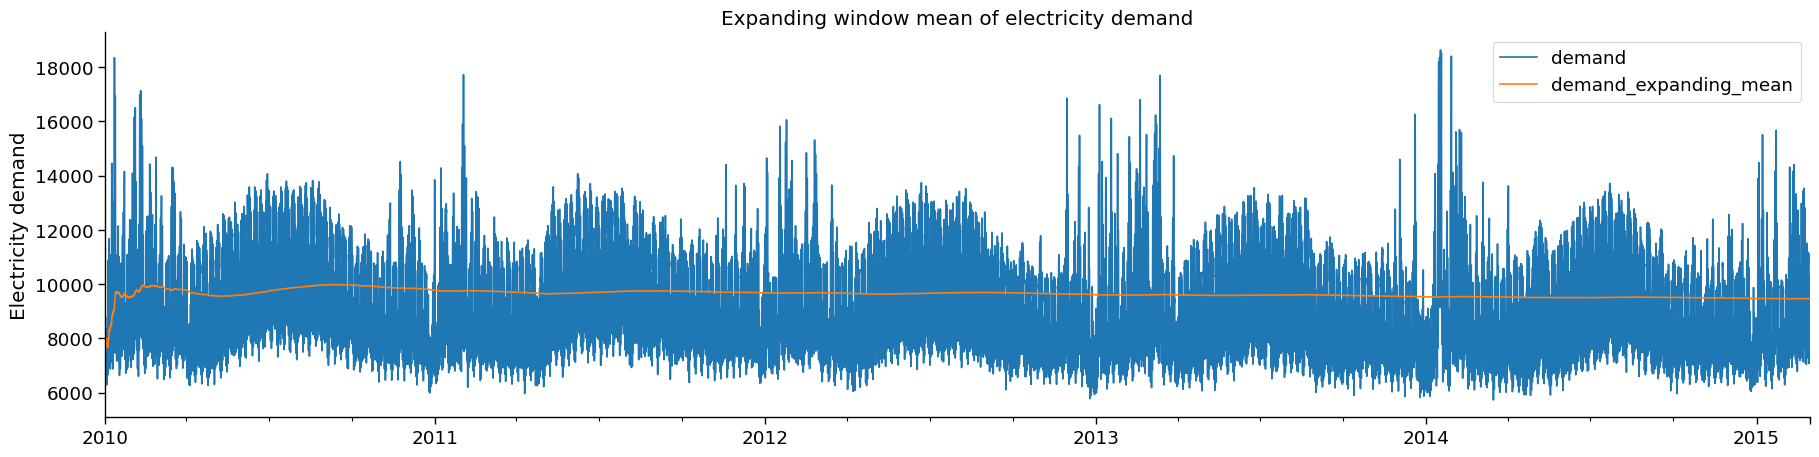

In [12]:
df.loc[:, ["demand", "demand_expanding_mean"]].plot()

plt.title("Expanding window mean of electricity demand")
plt.ylabel("Electricity demand")
plt.xlabel("")
plt.show()